# Test Algorithms 

1) Иерархическая кластеризация 
2) К — средних
3) DBSCAN
4) Разделения смеси гауссиан (EM). 


In [1]:
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import set_random_seed 
import os
import random as rn 
import pandas as pd
import pymorphy2
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

SEED = 32 
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

### Load processed texts

In [29]:
X_ = np.load('data_x.npy') 
Y_ = np.load('data_y.npy')

In [30]:
print(X_.shape)

(1906, 50)


In [31]:
print(Y_.shape)

(1906,)


### Fetch 20 news groups

dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
data_test = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42)
print('data loaded')

data loaded


In [5]:
y_train, y_test = data_train.target, data_test.target

In [6]:
%%time
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

CPU times: user 6.45 s, sys: 16 ms, total: 6.46 s
Wall time: 6.47 s


In [7]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=50): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(x) 
    return x1 

In [8]:
%%time
X_train_ = encode_svd(X_train)

CPU times: user 1min 40s, sys: 1min 20s, total: 3min
Wall time: 1min 26s


In [9]:
y_train[y_train==1]
print(len(np.unique(y_train)), len(y_train))

20 11314


In [10]:
X_ = X_train_[:]
Y_ = y_train[:]

In [11]:

print(X_.shape)
print(Y_.shape)
print(np.unique(Y_))

(11314, 50)
(11314,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Берем только 10 первых классов 0-9

In [13]:
yindex = Y_[Y_ < 8]
xindex = X_[Y_ < 8]
print(len(xindex), len(yindex))
X_ = xindex
Y_ = yindex

4595 4595


### Test

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics 

def test_cluster(x,y, model):   
    model.fit(x)
    labels = model.labels_
    
    scores = []
    scores.append(metrics.homogeneity_score(y, labels))
    scores.append(metrics.completeness_score(y, labels))
    scores.append(metrics.v_measure_score(y, labels))
    scores.append(metrics.adjusted_rand_score(y, labels))
    scores.append(metrics.adjusted_mutual_info_score(y, labels,
                                               average_method='arithmetic'))
    try:
        scores.append(metrics.silhouette_score(x, labels, metric='sqeuclidean'))
    except ValueError:
        scores.append(0.0)
    scores.append(len(np.unique(labels)))
     
    print("Homogeneity: %0.3f" %  scores[0])
    print("Completeness: %0.3f" % scores[1])
    print("V-measure: %0.3f" % scores[2])
    print("Adjusted Rand Index: %0.3f"  % scores[3])
    print("Adjusted Mutual Information: %0.3f"  % scores[4])
    print("Silhouette Coefficient: %0.3f"  % scores[5])
    print("labels num: %0.3f"  % scores[6])
    return scores

### Results

In [33]:
results = []
n_clusters = len(np.unique(Y_))
print(n_clusters)

10


### Model KMeans

In [34]:

from sklearn.cluster import KMeans

m1 = KMeans(n_clusters=n_clusters, random_state=SEED)
r = test_cluster(X_, Y_, m1)
results.append(r)

Homogeneity: 0.158
Completeness: 0.182
V-measure: 0.169
Adjusted Rand Index: 0.045
Adjusted Mutual Information: 0.160
Silhouette Coefficient: 0.089
labels num: 10.000


### Agglomerative Clustering

In [35]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
m2 = AgglomerativeClustering(n_clusters=n_clusters)
r = test_cluster(X_, Y_, m2)
results.append(r)

Homogeneity: 0.127
Completeness: 0.184
V-measure: 0.150
Adjusted Rand Index: 0.012
Adjusted Mutual Information: 0.139
Silhouette Coefficient: 0.108
labels num: 10.000


### DBSCAN

In [36]:
from sklearn.cluster import DBSCAN
m3 = DBSCAN(eps=0.212, min_samples = 2)
r = test_cluster(X_, Y_, m3)
results.append(r)

Homogeneity: 0.168
Completeness: 0.186
V-measure: 0.176
Adjusted Rand Index: -0.009
Adjusted Mutual Information: 0.085
Silhouette Coefficient: -0.177
labels num: 106.000


### GaussianMixture

In [40]:
from sklearn.mixture import GaussianMixture

class GM:
    
    def __init__(self, model):
        self.model = model
        self.labels_ = []
    
    def fit(self, x):
        self.model.fit(x)
        self.labels_ = self.model.predict(x)
        
        

m4 = GaussianMixture(n_components=n_clusters)
r = test_cluster(X_, Y_,GM(m4))
results.append(r)

Homogeneity: 0.130
Completeness: 0.162
V-measure: 0.144
Adjusted Rand Index: 0.055
Adjusted Mutual Information: 0.134
Silhouette Coefficient: 0.068
labels num: 10.000


### AL

In [16]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class Cluster:
    
    def __init__(self, n):
        ''' '''
        self.n = n # номер класетра (начальной точки)
        self.nodes = set([n]) # объединенные с кластером точки 
        self.join_n  = -1 # номер кластера с которым слит
        self.dist = -1 # расстояние при слиянии (dist <= 0)

    def active(self):
        ''' '''
        return self.join_n == -1
        
    def merge(self, c, dist):
        ''' '''
        self.nodes = self.nodes.union(c.nodes) 
        c.join_n = self.n
        c.dist = np.abs(dist)
        
    def get_n(self):
        ''' '''
        if self.join_n == -1:
            return self.n
        return self.join_n
        
class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
            
    
    def fit(self, x):
        ''' '''
        self._c_all = []
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size): 
            C.append( Cluster(i) )
        
        delta = self.delta
        
        for i in range(self.max_iteration): 
            d = np.min(M[M > 0])  
            #d = self._get_min(M, C) * self.alpha
            if d > delta:
                delta = d  
            delta = delta * self.alpha    
            if(self.debug):   
                print('delta: %.3f, d: %.3f' % (delta, d))    
            M_ = M - delta
            ''' join clusters '''
            join = False
        
            for i in range(size):  
                for j in range(i+1,size):  
                    
                    if(M[i][j] <= 0 or M_[i][j] > 0):
                        continue 
                        
                    if C[i].dist > np.abs(M_[i][j]): 
                        continue
                        
                    a = C[i].get_n()
                    b = C[j].get_n() 
                    if(a == b):
                        continue 
            
                    C[a].merge(C[b], M_[i][j]) 
                    for s in C[b].nodes:
                        #C[s].join_n = a
                        C[a].merge(C[s], M_[i][j])
                    join = True        
            if join == False: 
                delta = delta * self.betta 
                continue
            
            M =   M_ 
                    
            if len(M[M > 0]) == 0:
                break
               
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c.active() == True): 
                    for i in c.nodes:
                        y_[i] = cl
                    cl = cl + 1
                    
            self._c_all.append(y_)  
          
            if len(np.unique(y_)) <= self.n_clusters: 
                break
            neg,pos = [],[]    
            for i in range(size): 
                for j in range(i,size):
                    if C[i].active() == False:
                        continue
                    if C[j].active() == False:
                        continue
                        
                    if(M[i][j] <= 0):
                        neg.append(np.abs(M[i][j]) + delta)
                    elif(M[i][j] > 0):
                        pos.append(M[i][j])    
            if(self.debug):
                print('Sum pos: %.3f, sum neg: %.3f, Std pos: %.3f, Std neg: %.3f' % 
                      (sum(pos) , sum(neg) ,np.std(pos), np.std(neg))) 
            if np.std(pos) == 0:
                break
            if self.stop_neg_sum and sum(pos) / len(pos) < sum(neg) / len(neg): 
                print('sum(pos) < sum(neg)')
                break 
        self.labels_ = y_         
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [39]:
m5 = HierarchicalClustering(alpha=1,n_clusters=n_clusters,stop_neg_sum=False)
r = test_cluster(X_, Y_, m5)
results.append(r) 

Homogeneity: 0.009
Completeness: 0.210
V-measure: 0.017
Adjusted Rand Index: -0.003
Adjusted Mutual Information: 0.006
Silhouette Coefficient: 0.223
labels num: 8.000


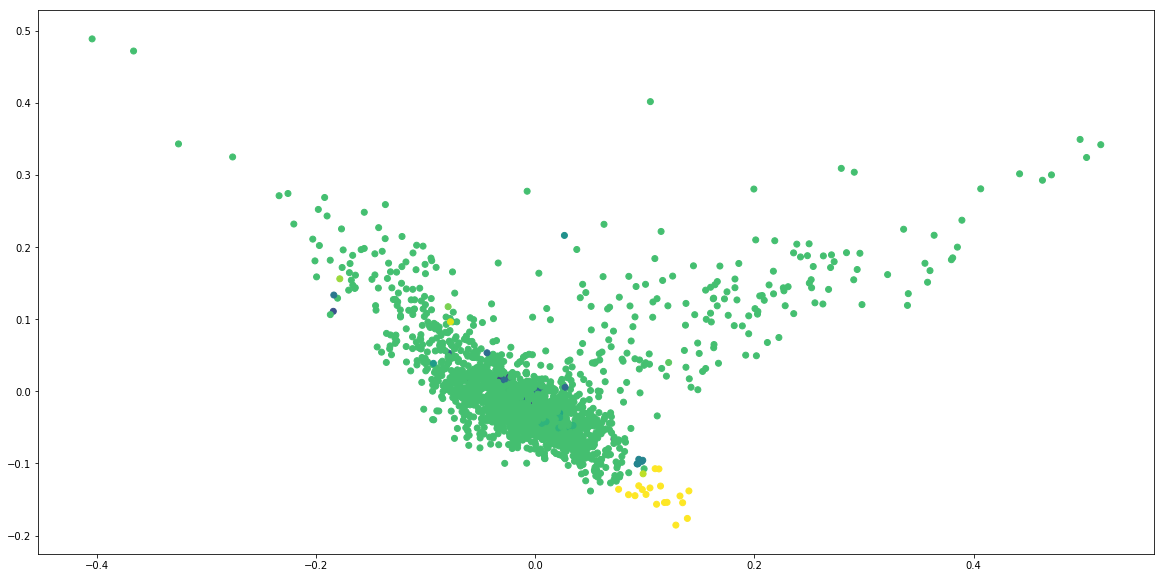

In [41]:
from sklearn.decomposition import PCA, SparsePCA, NMF

p = PCA(n_components=2)
x1 = p.fit_transform(X_)


plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x1[:,0], x1[:,1], c=m5._c_all[-2])

In [12]:
df2 = pd.DataFrame(results, columns=[ 
    'Homogeneity', 
    'Completeness', 
    'V-measure', 
    'Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient', 'len'])
df2.head(len(results))

,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information,Silhouette Coefficient,len
0,0.158236,0.182376,0.169450,0.044860,0.160114,0.088911,10
1,0.127000,0.184168,0.150333,0.011810,0.139469,0.108352,10
2,0.035664,0.245722,0.062288,-0.002691,0.017989,-0.466628,33
3,0.175493,0.186219,0.180697,0.073454,0.171884,0.031663,10
4,0.008606,0.210222,0.016535,-0.002967,0.006019,0.222945,8


In [44]:
from scipy.stats import ttest_ind
#from scipy.stats import 

?scipy.stats.t.ppf

Object `scipy.stats.t.ppf` not found.


In [16]:
np.round(df2.values, 2)

array([[ 0.14,  0.17,  0.15,  0.04,  0.14,  0.07, 10.  ],
       [ 0.1 ,  0.17,  0.13,  0.01,  0.12,  0.09, 10.  ],
       [ 0.01,  0.22,  0.02, -0.  ,  0.  , -0.04, 10.  ],
       [ 0.13,  0.17,  0.14,  0.04,  0.13,  0.05, 10.  ],
       [ 0.02,  0.25,  0.04, -0.  ,  0.02,  0.21, 10.  ]])

### Тест 2

Сравним 4 алгоритма на синтетических наборах данных

- HierarchicalClustering и DBSCAN как адаптивные алгоритмы

- HierarchicalClustering и AgglomerativeClustering как аглоритмически близкие

In [45]:
from sklearn  import datasets
 
#dx, dy    
def test_2algo(func_ds, test_alg):
    result1,result2 = [],[] 

    for n in range(100): 
        bx,by = func_ds()
        n_clusters = len(np.unique(by))
        print(n_clusters)
        
        m5 = HierarchicalClustering(alpha=1,n_clusters=n_clusters,debug=0)
        r = test_cluster(bx, by, m5)
        result1.append(r) 

        m3 = test_alg #DBSCAN(min_samples = 2) #DBSCAN(eps=0.103, min_samples = 2)
        r = test_cluster(bx, by, m3)
        result2.append(r)

    df2_1 = pd.DataFrame(result1, columns=[ 
    'Homogeneity', 
    'Completeness', 
    'V-measure', 
    'Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient', 'len'])
    df2_2 = pd.DataFrame(result2, columns=[ 
    'Homogeneity', 
    'Completeness', 
    'V-measure', 
    'Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient', 'len'])
    
    ###
    # 200 - 2 = 198 => 180-199	1.973 # http://medstatistic.ru/theory/t_cryteria.html
    # http://medstatistic.ru/theory/t_cryteria.html
    ss = 1.973
    for c in df2_1.columns:
        tStat = ttest_ind(df2_1[c].values, df2_2[c].values)
        z = "<"
        if df2_1[c].mean() > df2_2[c].mean():
            z = ">"
        print('%s: important: %s, alg1: %.4f, alg2: %.4f %s %.4f' % (c, np.abs(tStat.statistic) > ss, tStat.statistic, df2_1[c].mean(), z, df2_2[c].mean()))


####  2 класса

In [46]:
 
def ds2():
    return datasets.make_blobs(n_samples=100,  n_features=3, cluster_std=1 + np.random.rand())
 

test_2algo(ds2, DBSCAN(eps=0.212, min_samples = 2))

3
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.864
labels num: 2.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.195
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.931
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.822
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.0

Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.951
labels num: 2.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.437
labels num: 3.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.393
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.959
labels num: 3.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.157
labels num: 2.00

Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.836
labels num: 2.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.945
labels num: 2.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: 0.111
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.924
labels num: 3.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.011
labels num: 2.000

Homogeneity: 0.590
Completeness: 0.895
V-measure: 0.711
Adjusted Rand Index: 0.556
Adjusted Mutual Information: 0.704
Silhouette Coefficient: 0.491
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.893
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000


In [47]:
test_2algo(ds2, AgglomerativeClustering(n_clusters = 2))

3
Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.740
labels num: 3.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.882
labels num: 2.000
3
Homogeneity: 0.590
Completeness: 0.935
V-measure: 0.724
Adjusted Rand Index: 0.570
Adjusted Mutual Information: 0.717
Silhouette Coefficient: 0.642
labels num: 3.000
Homogeneity: 0.584
Completeness: 1.000
V-measure: 0.737
Adjusted Rand Index: 0.574
Adjusted Mutual Information: 0.734
Silhouette Coefficient: 0.920
labels num: 2.000
3
Homogeneity: 0.584
Completeness: 0.935
V-measure: 0.719
Adjusted Rand Index: 0.560
Adjusted Mutual Information: 0.712
Silhouette Coefficient: 0.595
labels num: 3.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.920
labels num: 2.00

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.917
labels num: 3.000
Homogeneity: 0.584
Completeness: 1.000
V-measure: 0.737
Adjusted Rand Index: 0.574
Adjusted Mutual Information: 0.734
Silhouette Coefficient: 0.781
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.857
labels num: 3.000
Homogeneity: 0.584
Completeness: 1.000
V-measure: 0.737
Adjusted Rand Index: 0.574
Adjusted Mutual Information: 0.734
Silhouette Coefficient: 0.682
labels num: 2.000
3
Homogeneity: 0.010
Completeness: 0.200
V-measure: 0.019
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: -0.145
labels num: 2.000
Homogeneity: 0.542
Completeness: 0.930
V-measure: 0.685
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.681
Silhouette Coefficient: 0.605
labels num: 2.000

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.937
labels num: 3.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.818
labels num: 2.000
3
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.858
labels num: 2.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.858
labels num: 2.000
3
Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.749
labels num: 3.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.882
labels num: 2.000


Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.911
labels num: 3.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.842
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.971
labels num: 3.000
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.782
labels num: 2.000
3
Homogeneity: 0.596
Completeness: 0.897
V-measure: 0.716
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.709
Silhouette Coefficient: 0.417
labels num: 3.000
Homogeneity: 0.584
Completeness: 1.000
V-measure: 0.737
Adjusted Rand Index: 0.574
Adjusted Mutual Information: 0.734
Silhouette Coefficient: 0.829
labels num: 2.000


#### 10 класса


In [49]:
def ds10():
    return datasets.make_classification(n_classes=10, n_informative=10)

test_2algo(ds10, DBSCAN(eps=0.212, min_samples = 2))

10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.005
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.501
V-measure: 0.668
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.006
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.332
Completeness: 0.444
V-measure: 0.380
Adjusted Rand Index: 0.009
Adjusted Mutual Information: 0.020
Silhouette Coefficient: -0.278
labels num: 32.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mut

Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.012
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.246
Completeness: 0.412
V-measure: 0.308
Adjusted Rand Index: 0.001
Adjusted Mutual Information: -0.002
Silhouette Coefficient: -0.206
labels num: 24.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.500
V-measure: 0.667
Adjusted Rand Index: 0.004
Adjusted Mut

sum(pos) < sum(neg)
Homogeneity: 0.215
Completeness: 0.427
V-measure: 0.286
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.016
Silhouette Coefficient: -0.238
labels num: 20.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.248
Completeness: 0.426
V-measure: 0.314
Adjusted Rand Index: -0.001
Adjusted Mutual Information: 0.008
Silhouette Coefficient: -0.182
labels num: 24.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.663
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutu

Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.010
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.249
Completeness: 0.428
V-measure: 0.315
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.009
Silhouette Coefficient: -0.290
labels num: 24.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.501
V-measure: 0.668
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.663
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.006
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: important: True, alg1: 25.5204, alg2: 0.8206 > 0.0000
Completeness: important: True, alg1: -162.8476, alg2: 0.4822 < 1.0000
V-measure: important: True, alg1: 35.7442, alg2: 0.5794 > 0.0000
Adjusted Rand Index: important: True, alg1: 4.8142, alg2: 0.0017 > 0.0000
Adjusted Mutual Information: im

In [26]:
test_2algo(ds10, AgglomerativeClustering(n_clusters = 10))

10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.009
labels num: 99.000
Homogeneity: 0.349
Completeness: 0.355
V-measure: 0.352
Adjusted Rand Index: 0.090
Adjusted Mutual Information: 0.175
Silhouette Coefficient: 0.143
labels num: 10.000
10
Homogeneity: 0.071
Completeness: 0.422
V-measure: 0.122
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: -0.199
labels num: 8.000
Homogeneity: 0.247
Completeness: 0.277
V-measure: 0.261
Adjusted Rand Index: 0.038
Adjusted Mutual Information: 0.072
Silhouette Coefficient: 0.166
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.247
Completeness: 0.405
V-measure: 0.307
Adjusted Rand Index: 0.002
Adjusted Mutual Information: -0.004
Silhouette Coefficient: -0.180
labels num: 24.000
Homogeneity: 0.263
Completeness: 0.270
V-measure: 0.267
Adjusted Rand Index: 0.030
Adjusted Mutual Information: 

sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.313
Completeness: 0.328
V-measure: 0.320
Adjusted Rand Index: 0.081
Adjusted Mutual Information: 0.142
Silhouette Coefficient: 0.132
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.009
labels num: 99.000
Homogeneity: 0.283
Completeness: 0.299
V-measure: 0.291
Adjusted Rand Index: 0.057
Adjusted Mutual Information: 0.104
Silhouette Coefficient: 0.147
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.502
V-measure: 0.668
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.322
Completeness: 0.343
V-measure: 0.332
Adjusted Rand Index: 0.085
Adjusted Mut

sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.004
labels num: 99.000
Homogeneity: 0.283
Completeness: 0.308
V-measure: 0.295
Adjusted Rand Index: 0.046
Adjusted Mutual Information: 0.111
Silhouette Coefficient: 0.158
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.009
labels num: 99.000
Homogeneity: 0.322
Completeness: 0.337
V-measure: 0.329
Adjusted Rand Index: 0.073
Adjusted Mutual Information: 0.149
Silhouette Coefficient: 0.161
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.444
Completeness: 0.399
V-measure: 0.420
Adjusted Rand Index: 0.014
Adjusted Mutual Information: 0.032
Silhouette Coefficient: -0.184
labels num: 38.000
Homogeneity: 0.234
Completeness: 0.254
V-measure: 0.244
Adjusted Rand Index: 0.021
Adjusted Mu

sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.005
labels num: 99.000
Homogeneity: 0.253
Completeness: 0.269
V-measure: 0.261
Adjusted Rand Index: 0.030
Adjusted Mutual Information: 0.073
Silhouette Coefficient: 0.143
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.501
V-measure: 0.667
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.004
labels num: 99.000
Homogeneity: 0.271
Completeness: 0.293
V-measure: 0.282
Adjusted Rand Index: 0.043
Adjusted Mutual Information: 0.092
Silhouette Coefficient: 0.141
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.501
V-measure: 0.668
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.013
labels num: 99.000
Homogeneity: 0.263
Completeness: 0.282
V-measure: 0.272
Adjusted Rand Index: 0.041
Adjusted Mutua

In [69]:
#print(result3)